# Markov Chain Monte Carlo using preconditioned Crank Nicolson proposals.

This notebook demonstrates the use of standard Metropolis-Hastings MCMC, using pCN proposals to sample the posteriors of the minimum of the Rosenbrock and Ackley functions given some Gaussian priors, respectively.
<br><br>
#### NB! I have since written a much better MCMC implementation, with some examples that can be adapted. 
#### It can be found at https://github.com/mikkelbue/tinyDA

In [1]:
# Import the good stuff.
import numpy as np
from numpy import dot
from numpy.linalg import inv, det
import matplotlib.pyplot as plt

import tqdm

## Base classes: Link and Chain

In [2]:
# Link is an abstract class that can be extended with actual evaluation, prior and likelihood methods.
# It holds member parameters and functions that are unique to each link.
class Link:
    def __init__(self, params, prior_location, prior_scale, likelihood_scale):
        self.params = np.array(params)
        self.prior_location = prior_location
        self.prior_scale = prior_scale
        self.likelihood_scale = likelihood_scale
        self.output = self.evaluate()
    
    # The following methods are just placeholders, so that more useful 
    # methods can be created with inheritance. The class is set up
    # To handle log-likelihoods rather than likelihoods.
    def evaluate(self):
        return 0
    
    def prior(self):
        return 0
    
    def likelihood(self):
        return 0

    def posterior(self):
        return self.prior() + self.likelihood()

In [3]:
# Chain implements the preconditioned Crank-Nicolson proposal distribution and standard Metropolis-Hastings MCMC.
class Chain:
    def __init__(self, prior_scale, likelihood_scale, beta_pCN):
        
        self.beta = beta_pCN
        self.prior_location = np.zeros(prior_scale.shape[0])
        self.prior_scale = prior_scale
        self.likelihood_scale = likelihood_scale
        
        # Create an initial random link from the prior
        initial_parameters  = np.random.multivariate_normal(self.prior_location, self.prior_scale)
        
        # Create a chain and put the first link in it.
        self.chain = [Link(initial_parameters, 
                           self.prior_location, 
                           self.prior_scale, 
                           self.likelihood_scale)]
        
        # Create an empty list for acceptance budgeting.
        self.acceptance = []
        
    # preconditioned Crank Nicolson (pCN) proposal is created, based on the previous link.
    def proposal(self, previous_link):
        return np.sqrt(1 - self.beta**2)*previous_link.params + self.beta*np.random.multivariate_normal(self.prior_location, self.prior_scale)
    
    # This method implements the standard Metrpolis Hastings MCMC algorithm 
    # and extends the chain according to the number of iterations
    def run(self, iterations):
        for i in tqdm.tqdm(range(iterations)):
            new_proposal = Link(self.proposal(self.chain[-1]), 
                                self.prior_location, 
                                self.prior_scale, 
                                self.likelihood_scale)
            
            alpha = np.exp(new_proposal.likelihood() - self.chain[-1].likelihood())
            
            if np.random.random() < alpha:
                self.chain += [new_proposal]
                self.acceptance += [1]
            else:
                self.chain += [self.chain[i]]
                self.acceptance += [0]

## The Rosenbrock function

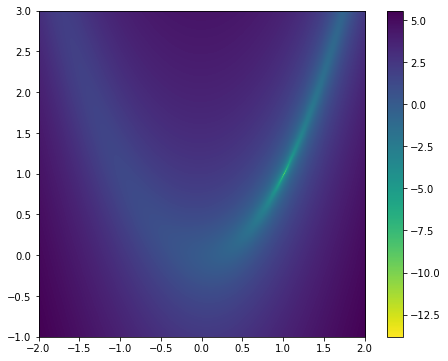

In [4]:
# An example of the Rosenbrock function, which is the first function
# that we will try and estimate with the MCMC.
def rosenbrock(x,y):
    return (1-x)**2 + 10*(y-x**2)**2

xx = np.linspace(-2,2, 1000); yy = np.linspace(-1,3, 1000); X, Y = np.meshgrid(xx,yy)
surf = rosenbrock(X,Y)
plt.figure(figsize = (8,6))
# The log of the function values are plotted since it scales better with the colormap.
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.show()

In [5]:
# The link class is extended for use with the Rosenbrock function.
class Link(Link):
    # This is the formula for the Rosenbrock function
    def evaluate(self):
        return (1-self.params[0])**2 + 10*(self.params[1] - self.params[0]**2)**2
    
    # We do not require the prior for pCN proposal.
    
    # Likelihood is computed using squared L2 norm likelihood function.
    def likelihood(self):
        return -np.linalg.norm(self.output)**2/(2*self.likelihood_scale)

In [6]:
# All the relevant parameters are set.
prior_scale = np.diag([1, 1])
likelihood_scale = 1
beta_pCN = 0.18

# A chain is instantiated and run for a number of iterations
chain = Chain(prior_scale, likelihood_scale, beta_pCN)
chain.run(100000)

100%|██████████| 100000/100000 [00:11<00:00, 8472.91it/s]


Acceptance rate: 0.6345816326530612


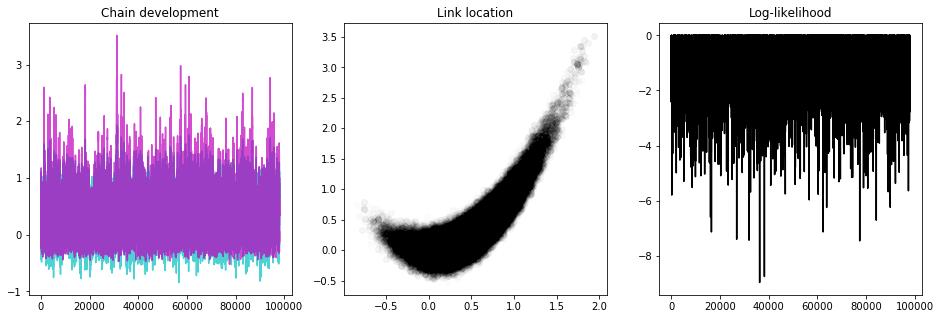

In [7]:
# Set the burnin.
burnin = 2000

# Print the acceptance ratio
print('Acceptance rate: {}'.format(np.mean(chain.acceptance[burnin:])))

# Do some nice plotting of the chain.
x = [i.params[0] for i in chain.chain][burnin:]
y = [i.params[1] for i in chain.chain][burnin:]
post_prob = [i.likelihood() for i in chain.chain][burnin:]

fig, axs = plt.subplots(1, 3, figsize=(16,5))

xplot = axs[0].plot(x, color = 'c', alpha = 0.7); 
yplot = axs[0].plot(y, color = 'm', alpha = 0.7); axs[0].set_title('Chain development')
location = axs[1].scatter(x, y, color = 'k', alpha = 0.01); axs[1].set_title('Link location')
posterior = axs[2].plot(post_prob, color = 'k'); axs[2].set_title('Log-likelihood')
plt.show()

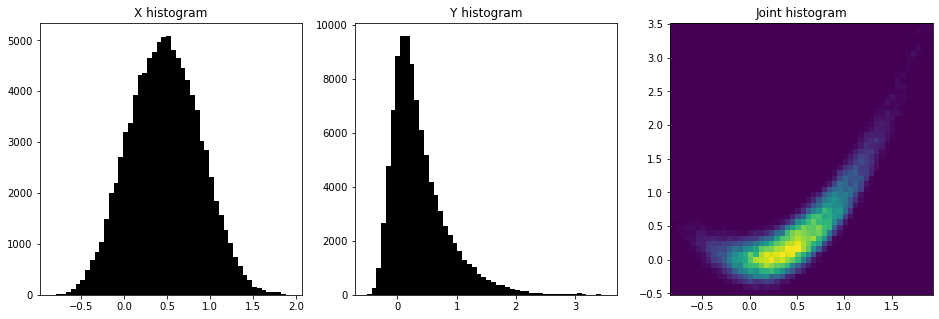

In [8]:
# More plotting. Histograms!
fig, axs = plt.subplots(1, 3, figsize=(16,5))
xhist = axs[0].hist(x, bins = 50, color = 'k'); axs[0].set_title('X histogram')
yhist = axs[1].hist(y, bins = 50, color = 'k'); axs[1].set_title('Y histogram')
jhist = axs[2].hist2d(x, y, bins = (50, 50)); axs[2].set_title('Joint histogram');
plt.show()

## The Ackley function.

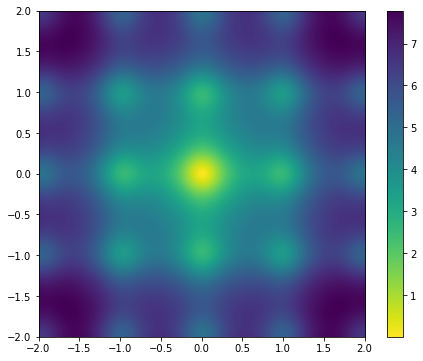

In [9]:
# An example of the Ackley function, which is the second function
# that we will try and estimate with the MCMC.

def ackley(x,y):
    return -20*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))) + 22.7182818284590446

xx = np.linspace(-2,2, 1000); yy = np.linspace(-2,2, 1000); X, Y = np.meshgrid(xx,yy)
surf = ackley(X,Y)
plt.figure(figsize = (8,6))
plt.imshow(surf, origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -2, 2]); plt.colorbar()
plt.show()

In [10]:
# The link class is extended, this time evaluated for the Ackley function.
class Link(Link):
    def evaluate(self):
        return -20*np.exp(-0.2*np.sqrt(0.5*(self.params[0]**2+self.params[1]**2)))-np.exp(0.5*(np.cos(2*np.pi*self.params[0])+np.cos(2*np.pi*self.params[1]))) + 20 + np.exp(1)
    
   # We do not require the prior for pCN proposal.
    
    # The likelihood is computed using squared L2 norm.
    def likelihood(self):
        return -np.linalg.norm(self.output)**2/(2*self.likelihood_scale)

In [11]:
# All the parameters are set.
prior_scale = np.diag([1, 1])
likelihood_scale = 1
beta_pCN = 0.4

# A chain is initialised and run for some iterations
chain = Chain(prior_scale, likelihood_scale, beta_pCN)
chain.run(100000)

100%|██████████| 100000/100000 [00:13<00:00, 7225.98it/s]


Acceptance rate: 0.18801020408163266


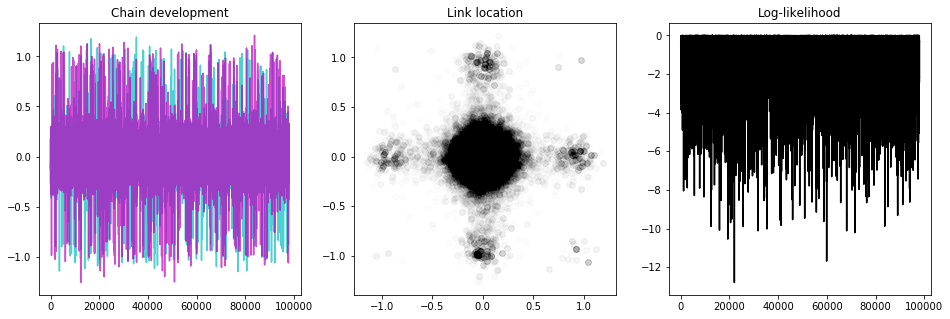

In [12]:
# Set the burnin.
burnin = 2000

# Print the acceptance ratio.
print('Acceptance rate: {}'.format(np.mean(chain.acceptance[burnin:])))

# Do some more plotting
x = [i.params[0] for i in chain.chain][burnin:]
y = [i.params[1] for i in chain.chain][burnin:]
loglike = [i.likelihood() for i in chain.chain][burnin:]

fig, axs = plt.subplots(1, 3, figsize=(16,5))

xplot = axs[0].plot(x, color = 'c', alpha = 0.7); 
yplot = axs[0].plot(y, color = 'm', alpha = 0.7); axs[0].set_title('Chain development')
location = axs[1].scatter(x, y, color = 'k', alpha = 0.01); axs[1].set_title('Link location')
posterior = axs[2].plot(loglike, color = 'k'); axs[2].set_title('Log-likelihood')
plt.show()

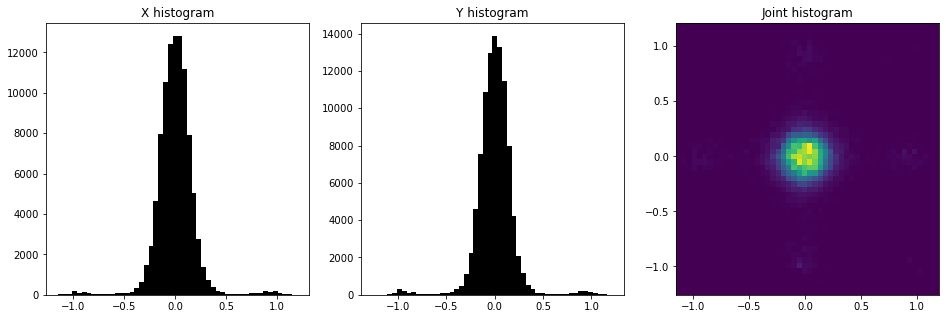

In [13]:
# More plotting. Histograms!
fig, axs = plt.subplots(1, 3, figsize=(16,5))
xhist = axs[0].hist(x, bins = 50, color = 'k'); axs[0].set_title('X histogram')
yhist = axs[1].hist(y, bins = 50, color = 'k'); axs[1].set_title('Y histogram')
jhist = axs[2].hist2d(x, y, bins = (50, 50)); axs[2].set_title('Joint histogram');
plt.show()